## Deep Neural Network for Image Classification: Application
在这一节我们将使用在上一节任务中实现的建立深度神经网络的函数应用于猫图或非猫图的分类。有希望地，将会看见与之前的logistic回归实现相比正确率有很大的进步。任务：建立一个深度神经网络并且应用于监督学习。

### 1 packages
首先还是比较常规的用到的包，numpy matplotlib h5py
PIL and scipy 最后使用你自己的图片来测试你的模型
dnn_app_utils 提供了你在上一节“step by step”里面实现的函数
np.random.seed(1)是用来保证所有的random函数调用的一致性

In [9]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### dataset
你将使用第二章作业的用于逻辑回归实践的猫图非猫图数据集，在逻辑回归模型中，正确率是70%，希望在这一节中有更好的模型得到更高的正确率。
问题陈述：
1. 你又两个数据集：m_train 有标签cat(1)或者non cat(0)； 以及m_test数据集
2. 每一张图片的数据都是shape(num_px,num_px,3) 3表示有3个通道

再次熟悉一下数据集，加载数据使用下面框中的代码

In [10]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

下面的代码是展示数据集里的一张图片的，你可以任意的修改索引index的大小，看数据集里的其他图片。train_y[0,index],train_y是一个一行m列的矩阵，表示的是所有训练样本的标记结果，所以train_y[0,index]表示的是取0行index列的值，也就是第在一行数里面，第index个的图片的标记结果。

y = 0. It's a non-cat picture.


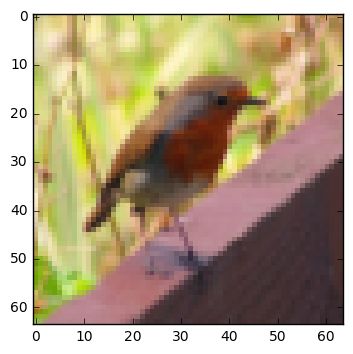

In [11]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [12]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209L, 64L, 64L, 3L)
train_y shape: (1L, 209L)
test_x_orig shape: (50L, 64L, 64L, 3L)
test_y shape: (1L, 50L)


通常情况下，下一步你应该reshape并且standardize这些图片，在你把它们喂进神经网络之前。即进行把图片转化成向量的操作。
首先我们知道对于神经网络，输入的X应该为一个（n_x，m）的矩阵，因此在train_x_orig的基础上将一个四维的数据变成二维的矩阵，原本的四维的矩阵则是有多少训练样本，每个样本的三个维度上的特征，现在保留训练样本，将三个维度特征展平在一个维度上。并且为了满足（n_x，m），还要做一个转置操作。将最后得到的二维矩阵除以255表示像素点的大小，将所有的数值都标准化。

In [13]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288L, 209L)
test_x's shape: (12288L, 50L)


### 3 模型的结构
现在你已经对数据集非常熟悉了，是时候来建立一个深度神经网络来区分猫图还是非猫图。你将建立两种模型：
1. 双层神经网络
2. L层深度神经网络
然后你就可以比较这些模型的性能，并且尝试不同的L值，即神经网络的层数。

#### 3.1 双层神经网络
双层神经网络的结构可以简化成：
INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.
1. 输入是一个（64,64,3）三维的图片，但是已经被展开成一个向量，即（12288,1）维的矩阵。
2. 作为单个样本的特征向量，会跟一个（n[1],12288）的W[1]矩阵相乘
3. 接下来再加上一个偏置向量b，最后放进relu函数里面计算出a值，得到一个a[1],即第一层计算出来的激活值。
4. 接下来用第一层计算出来的激活值再乘以W[2]，并且加上b[2]，再放进sigmoid函数
5. 放进sigmoid函数之后，就能得到最后的结果，如果这个结果大于0.5，那么可以把这个样本分类为猫图。

#### 3.2 L层深度神经网络
要像上面的描述一样来表示一个L层的神经网络是很困难的，下面是一个简单的表示：
The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID。

#### 3.3 习惯方法
1. 初始化参数/定义超参数
2. 循环：
    a. 前向传播
    b、计算代价函数
    c、反向传播
    d、更新参数
3. 使用训练好的参数去预测标签

### 4. 双层神经网络
问题： 使用在上一节你已经实现的关于双层神经网络的辅助函数来建立一个双层神经网络模型，结构为LINEAR -> RELU -> LINEAR -> SIGMOID。
关于你可能用到的函数的输入输出如下：
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [14]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [15]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.69304973566
Cost after iteration 100: 0.646432095343
Cost after iteration 200: 0.632514064791
Cost after iteration 300: 0.601502492035
Cost after iteration 400: 0.560196631161
Cost after iteration 500: 0.515830477276
Cost after iteration 600: 0.475490131394
Cost after iteration 700: 0.433916315123
Cost after iteration 800: 0.40079775362
Cost after iteration 900: 0.358070501132
Cost after iteration 1000: 0.339428153837
Cost after iteration 1100: 0.30527536362
Cost after iteration 1200: 0.274913772821
Cost after iteration 1300: 0.246817682106
Cost after iteration 1400: 0.198507350375
Cost after iteration 1500: 0.174483181126
Cost after iteration 1600: 0.170807629781
Cost after iteration 1700: 0.113065245622
Cost after iteration 1800: 0.0962942684594
Cost after iteration 1900: 0.0834261795973
Cost after iteration 2000: 0.0743907870432
Cost after iteration 2100: 0.0663074813227
Cost after iteration 2200: 0.0591932950104
Cost after iteration 2300: 0.0533614034856
C

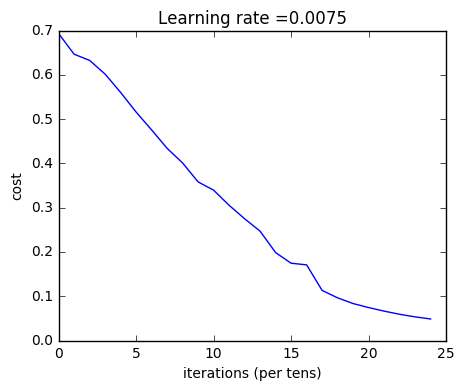

In [16]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

现在你已经实现了训练集样本喂入双层神经网络模型，并且已经通过更新参数，让正确率变高了，代价函数值变小，同时，你通过向量化实现的方式实现了对整个样本的操作，否则你可能需要10倍更多的时间来训练这些样本。
现在你就可以用这些训练好的参数来对训练集的样本来进行预测，再和已知的标签进行对比，看看最后迭代2500次更新参数后，使多少训练集符合这个参数模型。

In [17]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [18]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


提示：在这两步得正确率的过程中，出现了一点小问题，得到的答案都是0，原因在于python2 和python3对除法的不同理解，我的运行环境是2.7，但是官方文档里面predict()方法得正确率的写法应该是3版本的，对于/除法，2版本中整除/整数=整数，3版本整数/整数=浮点数。所以我的解决办法就是去源代码里面修改了这里的除法，在样本总数m添加了转化为浮点数的操作。
![python2与python3除法区别](http://upload-images.jianshu.io/upload_images/5355764-8f2b3d0c67d811f1.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


你也许会主要到在测试集上运行这个模型，使用更少的迭代，例如1500次可能有更高的正确率，这被称为“early stopping”，在下一门课程中会讲到这个。Early stopping is a way to prevent overfitting.

尽管这里对于测试集的标签预测结果正确率只有72%，但是已经比我们之前的logitic回归的正确率70%高啦，接下来继续看看使用深层神经网络的效果又如何呢。

### 5 L层神经网络
问题：使用上一节已经实现的关于L层神经网络实现的辅助函数，完成L层神经网络建立，结构为： [LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID.
你需要用到的函数的输入输出如下：
```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [19]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

In [22]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


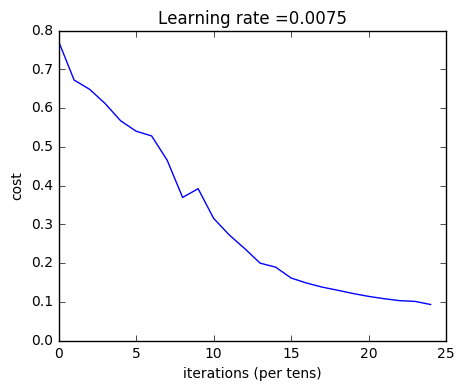

In [23]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [24]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.985645933014


In [25]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


这看起来在相同的测试数据集上，五层神经网络80%正确率比双层神经网络有更好的性能72%。在下一门课“提高深度神经网络”中，你将会学到如何获得更高的正确率通过系统的搜索最好的超参数（learning_rate，layers_dims，num_iterations，以及其他参数）。

### 6 结果分析
首先我们先看一下深度L层神经网络分类错误的图片，下面的代码将展示错误分类的图片。

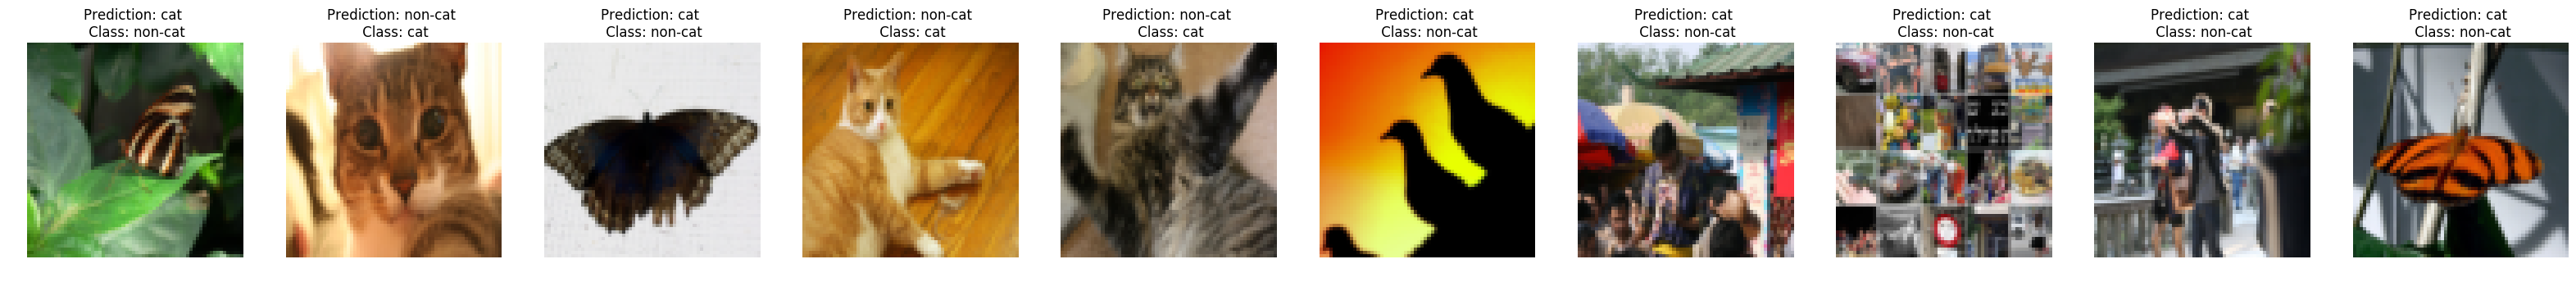

In [26]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

我们可以发现，有几种类型的图片分类结果往往不佳：
异常位置的猫体
猫在类似颜色的背景下出现。
罕见的猫色和种类
相机角度
画面的亮度
尺度变化（图像中的猫非常大或小）

### 7 使用你自己的图片来进行测试

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


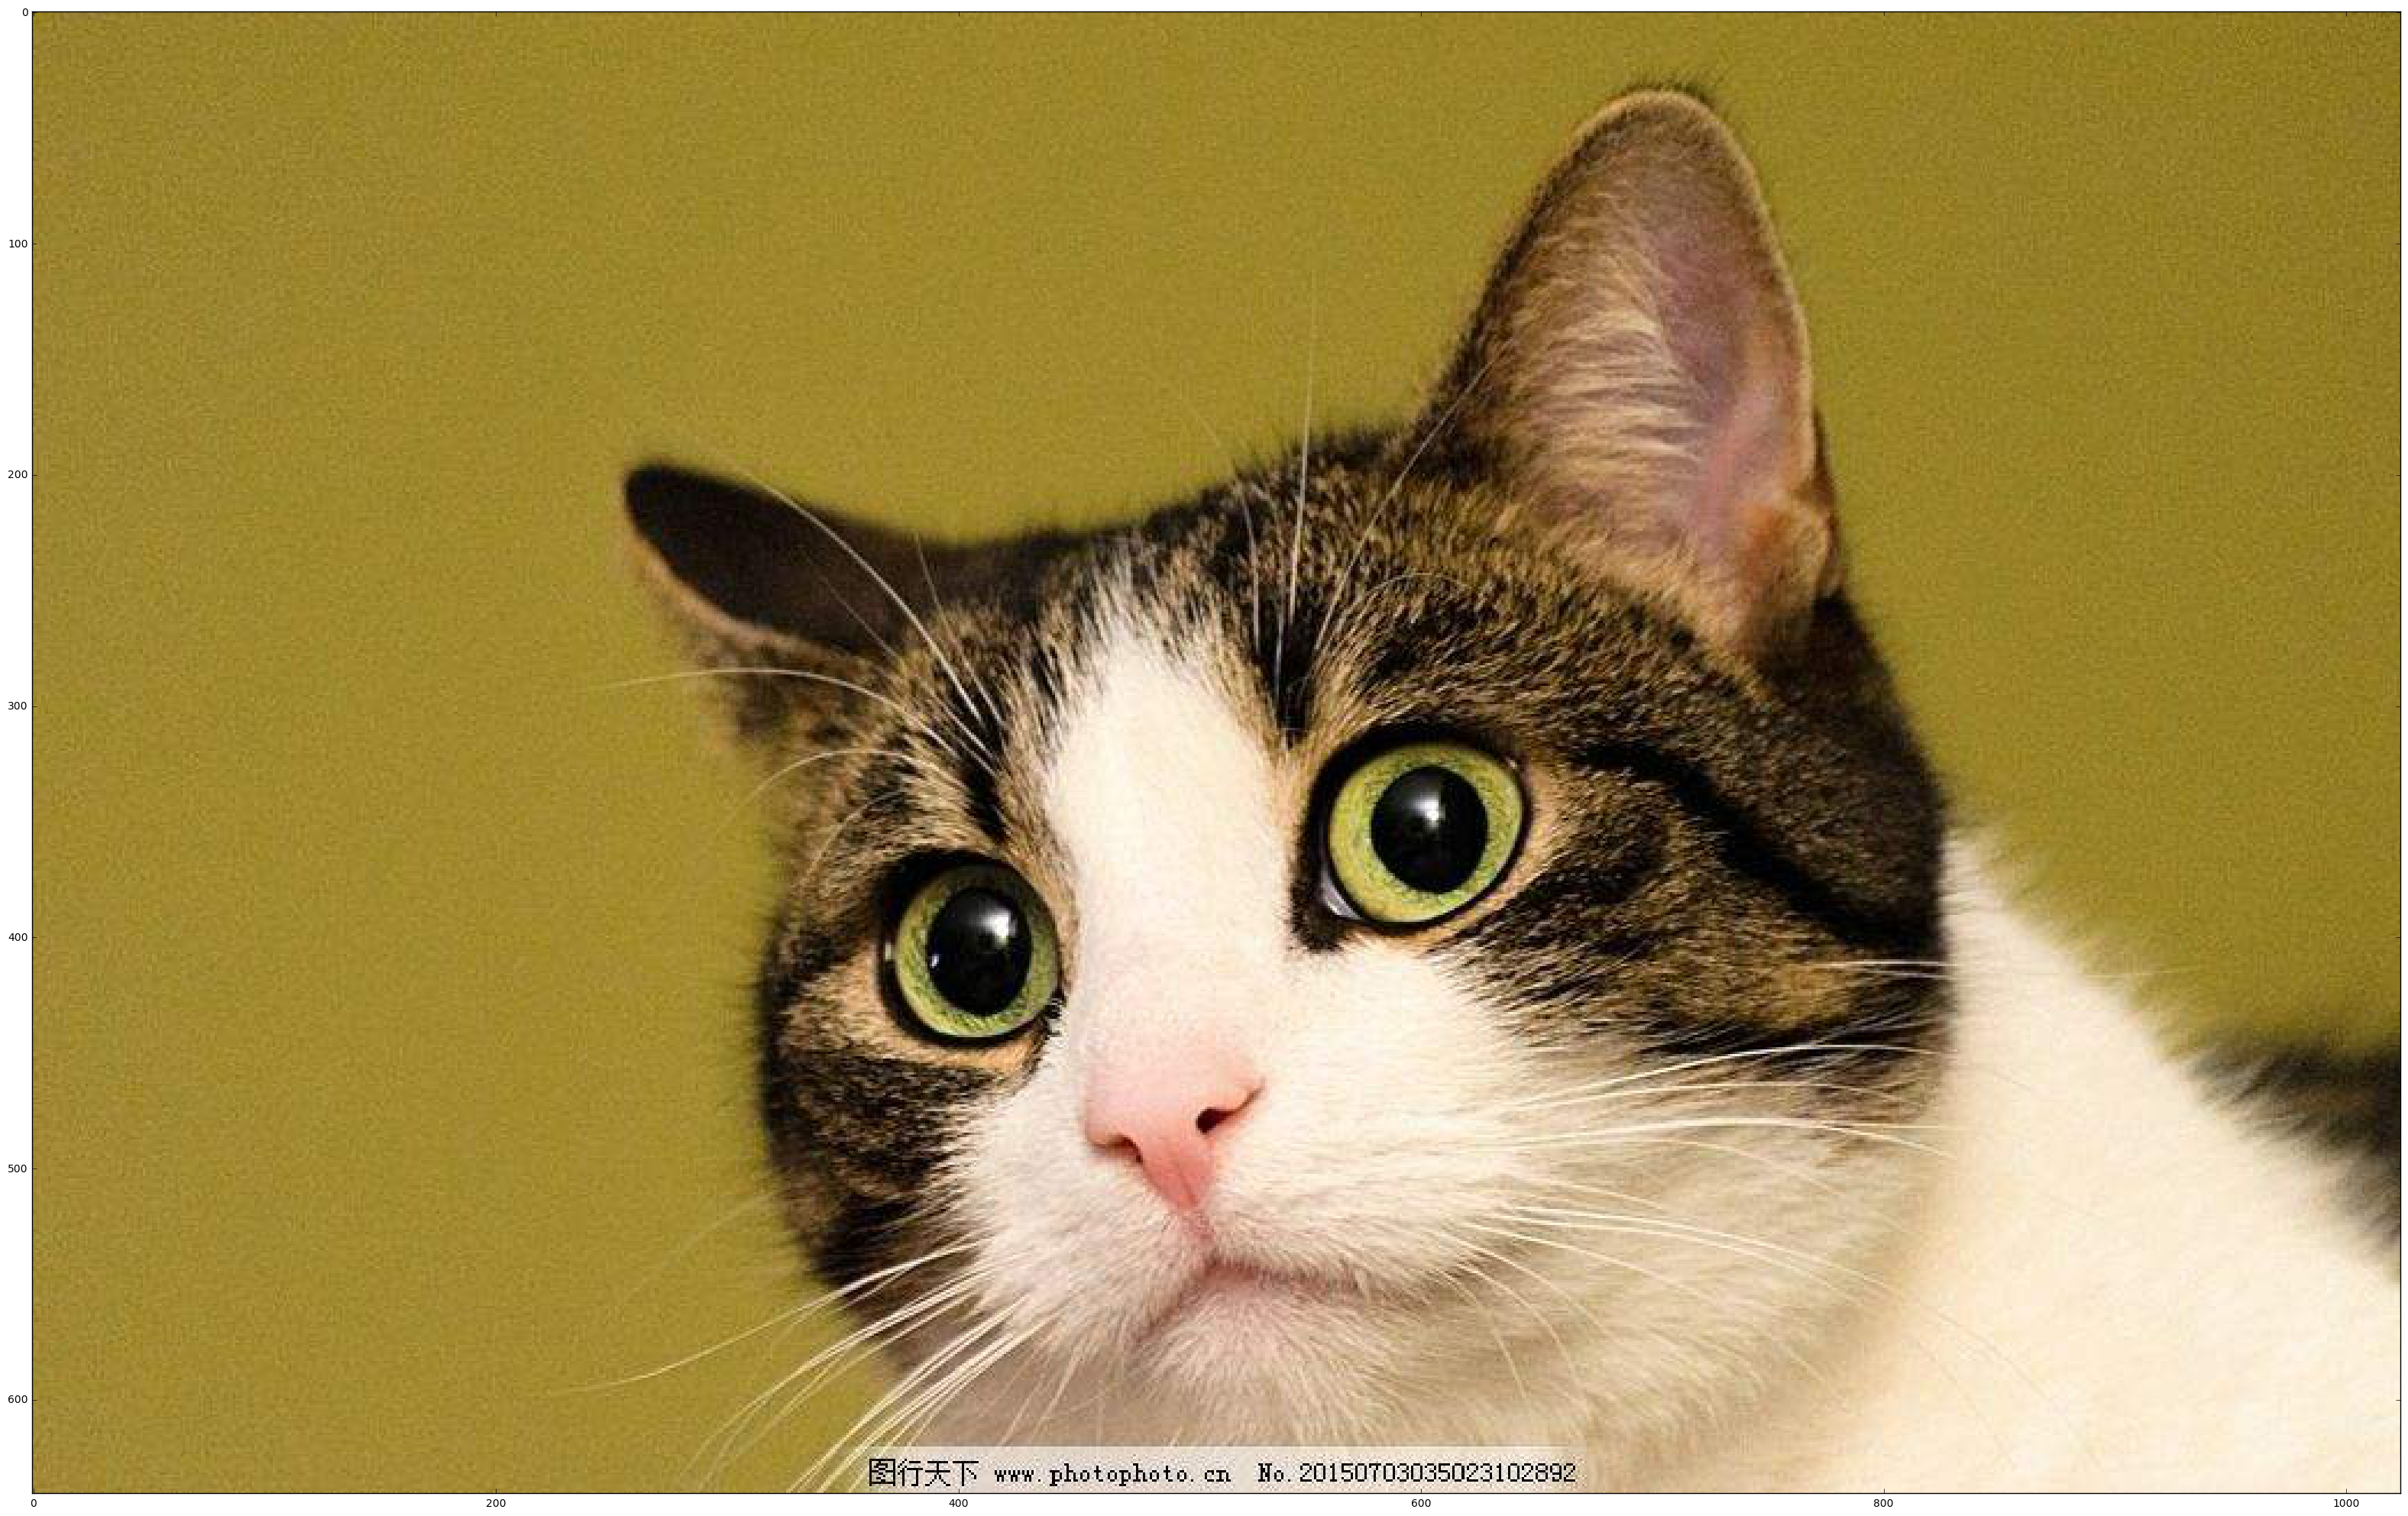

In [30]:
## START CODE HERE ##
my_image = "img1.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "./images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")